In [1]:
import nltk
# nltk.download()

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Define some very simple data for understanding

In [3]:
from nltk.corpus import brown

# Fetch sentences from the 'news' category of the Brown corpus
corpus = brown.sents(categories='news') 

# Convert sentences into a list of words for each sentence
corpus = [[word for word in sentence] for sentence in corpus]

# Print the first sentence as a list of words
print(corpus[0])


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

vocab

["ol'",
 'Georgia-Pacific',
 'finger',
 'waiting',
 'Mexico',
 'Franciscans',
 'leader',
 'nobody',
 'Decathlon',
 "Achaeans'",
 '$8',
 'inviolate',
 'retrenching',
 'Seminole',
 'bearings',
 'Thursday',
 'Fanning',
 'models',
 'feat',
 'disproportionate',
 'Bartha',
 'up',
 'filling',
 'legal',
 'execute',
 'Turkey',
 'Venable',
 'Tearle',
 "Bootle's",
 'prosperity',
 'Doxiadis',
 'Richmond',
 'rightfully',
 'code',
 'adjournment',
 'mentions',
 'us',
 'guardians',
 'Bay-front',
 'handing',
 'Eng.',
 'cloture',
 'Boy',
 'profits',
 'Intervenes',
 'incorrigible',
 'seventeen',
 'Conversion',
 'top',
 'gum',
 'Stickney',
 'Anticipated',
 'two-thirds',
 'gruonded',
 'masterful',
 'Neither',
 'Marine',
 'overlooked',
 '3-year-old',
 'intervene',
 "Throneberry's",
 'sensational',
 'Committees',
 'open',
 'Maynard',
 'rarity',
 'non-profit',
 'acquaint',
 'Well-wishers',
 'noise',
 'consider',
 'clown',
 'machines',
 'prompt',
 'ventilates',
 'probably',
 'Donnell',
 'bronzy-green-gold',
 "

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{"ol'": 0, 'Georgia-Pacific': 1, 'finger': 2, 'waiting': 3, 'Mexico': 4, 'Franciscans': 5, 'leader': 6, 'nobody': 7, 'Decathlon': 8, "Achaeans'": 9, '$8': 10, 'inviolate': 11, 'retrenching': 12, 'Seminole': 13, 'bearings': 14, 'Thursday': 15, 'Fanning': 16, 'models': 17, 'feat': 18, 'disproportionate': 19, 'Bartha': 20, 'up': 21, 'filling': 22, 'legal': 23, 'execute': 24, 'Turkey': 25, 'Venable': 26, 'Tearle': 27, "Bootle's": 28, 'prosperity': 29, 'Doxiadis': 30, 'Richmond': 31, 'rightfully': 32, 'code': 33, 'adjournment': 34, 'mentions': 35, 'us': 36, 'guardians': 37, 'Bay-front': 38, 'handing': 39, 'Eng.': 40, 'cloture': 41, 'Boy': 42, 'profits': 43, 'Intervenes': 44, 'incorrigible': 45, 'seventeen': 46, 'Conversion': 47, 'top': 48, 'gum': 49, 'Stickney': 50, 'Anticipated': 51, 'two-thirds': 52, 'gruonded': 53, 'masterful': 54, 'Neither': 55, 'Marine': 56, 'overlooked': 57, '3-year-old': 58, 'intervene': 59, "Throneberry's": 60, 'sensational': 61, 'Committees': 62, 'open': 63, 'Mayna

In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

14394


In [7]:
# append UNK
vocab.append('<UNK>')


In [8]:
vocab[-1:]

['<UNK>']

In [9]:
word2index['<UNK>'] = 0

In [10]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [11]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
X_i

Counter({'the': 5580,
         ',': 5188,
         '.': 4030,
         'of': 2849,
         'and': 2146,
         'to': 2116,
         'a': 1993,
         'in': 1893,
         'for': 943,
         'The': 806,
         'that': 802,
         '``': 732,
         'is': 732,
         'was': 717,
         "''": 702,
         'on': 657,
         'at': 598,
         'with': 545,
         'be': 526,
         'by': 497,
         'as': 481,
         'he': 451,
         'said': 402,
         'his': 399,
         'will': 389,
         'it': 363,
         'from': 344,
         'are': 328,
         ';': 314,
         'an': 300,
         'has': 300,
         '--': 300,
         'had': 279,
         'who': 268,
         'have': 265,
         'not': 254,
         'Mrs.': 253,
         'were': 252,
         'this': 250,
         'which': 244,
         'would': 244,
         'their': 219,
         'been': 212,
         'they': 205,
         'He': 191,
         'one': 184,
         'I': 179,
         'but'

In [12]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

skip_grams

[('Fulton', 'The'),
 ('Fulton', 'County'),
 ('County', 'Fulton'),
 ('County', 'Grand'),
 ('Grand', 'County'),
 ('Grand', 'Jury'),
 ('Jury', 'Grand'),
 ('Jury', 'said'),
 ('said', 'Jury'),
 ('said', 'Friday'),
 ('Friday', 'said'),
 ('Friday', 'an'),
 ('an', 'Friday'),
 ('an', 'investigation'),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('of', 'investigation'),
 ('of', "Atlanta's"),
 ("Atlanta's", 'of'),
 ("Atlanta's", 'recent'),
 ('recent', "Atlanta's"),
 ('recent', 'primary'),
 ('primary', 'recent'),
 ('primary', 'election'),
 ('election', 'primary'),
 ('election', 'produced'),
 ('produced', 'election'),
 ('produced', '``'),
 ('``', 'produced'),
 ('``', 'no'),
 ('no', '``'),
 ('no', 'evidence'),
 ('evidence', 'no'),
 ('evidence', "''"),
 ("''", 'evidence'),
 ("''", 'that'),
 ('that', "''"),
 ('that', 'any'),
 ('any', 'that'),
 ('any', 'irregularities'),
 ('irregularities', 'any'),
 ('irregularities', 'took'),
 ('took', 'irregularities'),
 ('took', 'place'),
 ('place', 'took')

In [13]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('of', 'the'): 844,
         ('the', 'of'): 844,
         ('in', 'the'): 549,
         ('the', 'in'): 549,
         (',', 'and'): 390,
         ('and', ','): 390,
         (',', 'the'): 364,
         ('the', ','): 364,
         ("''", '.'): 293,
         ('to', 'the'): 273,
         ('the', 'to'): 273,
         ('on', 'the'): 239,
         ('the', 'on'): 239,
         ('for', 'the'): 217,
         ('the', 'for'): 217,
         ("''", ','): 198,
         (',', "''"): 198,
         ('at', 'the'): 179,
         ('the', 'at'): 179,
         ('will', 'be'): 157,
         ('be', 'will'): 157,
         (';', ';'): 157,
         ('that', 'the'): 146,
         ('the', 'that'): 146,
         ('and', 'the'): 136,
         ('the', 'and'): 136,
         ('with', 'the'): 135,
         ('the', 'with'): 135,
         (',', 'who'): 126,
         ('who', ','): 126,
         ('said', ','): 123,
         (',', 'said'): 123,
         ('he', ','): 122,
         (',', 'he'): 122,
         (',', 'a')

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "figures/glove_weighting_func.png" width=400>

In [14]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [15]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")


Exception in callback BaseAsyncIOLoop._handle_events(1120, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(1120, 1)>
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\tornado\platform\asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 610, in _handle_events
    self._handle_recv()
  File "g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 639, in _handle_recv
    self._run_callback(callback, msg)
  File "g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 560, in _run_callback
    f = c

## 3. Prepare train data

In [16]:
for c in corpus:
    print(c)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']
['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.']
['``', 'Only', 'a', 'relative', 'handful', 'of', 'such', 'reports

In [17]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [18]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[6275]
 [3158]]
Target:  [[11558]
 [ 6275]]
Cooc:  [[0.69314718]
 [1.09861229]]
Weighting:  [[0.05318296]
 [0.07208434]]


In [19]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## 4. Model

<img src ="figures/glove.png">

In [20]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [21]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
import time

# Training
num_epochs = 50
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 10 | cost: 1.697423 | time: 0m 0s
Epoch: 20 | cost: 6.058060 | time: 0m 0s
Epoch: 30 | cost: 10.317233 | time: 0m 0s
Epoch: 40 | cost: 14.295948 | time: 0m 0s
Epoch: 50 | cost: 13.646516 | time: 0m 0s


## 6. Plotting the embeddings

In [24]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

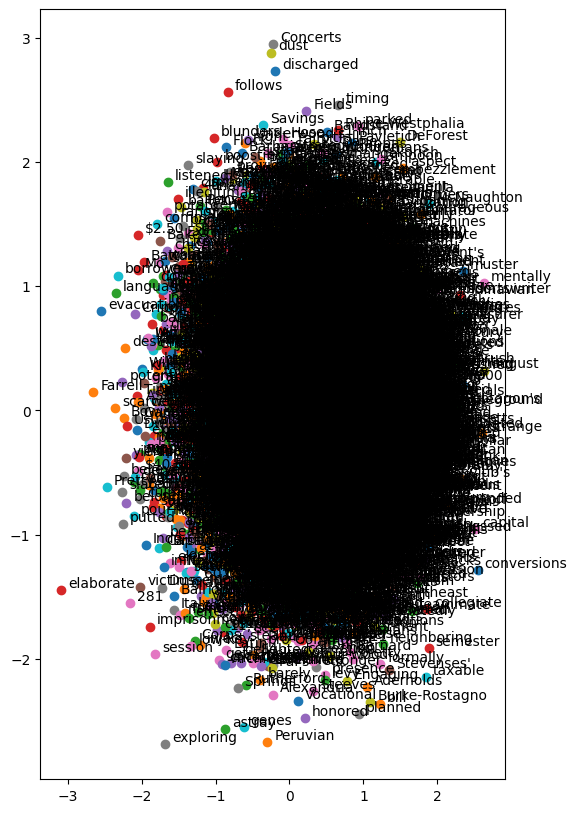

In [25]:
plt.figure(figsize=(6,10))
for i, word in enumerate(vocab[:]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [26]:
with open('word-test_semantic.txt', 'r') as file:
    # Read the entire file content
    # dataset = file.read() 
    # print(dataset)

    # Read the file line by line
    # for line in file:
    #     print(line.strip()) 

    # Read all lines into a list
    data_sem = file.readlines()
    print(data_sem)

with open('word-test_syntactic.txt', 'r') as file:
    # Read all lines into a list
    data_syn = file.readlines()
    print(data_syn)

['Athens Greece Baghdad Iraq\n', 'Athens Greece Bangkok Thailand\n', 'Athens Greece Beijing China\n', 'Athens Greece Berlin Germany\n', 'Athens Greece Bern Switzerland\n', 'Athens Greece Cairo Egypt\n', 'Athens Greece Canberra Australia\n', 'Athens Greece Hanoi Vietnam\n', 'Athens Greece Havana Cuba\n', 'Athens Greece Helsinki Finland\n', 'Athens Greece Islamabad Pakistan\n', 'Athens Greece Kabul Afghanistan\t\n', 'Athens Greece London England\n', 'Athens Greece Madrid Spain\t\n', 'Athens Greece Moscow Russia\t\n', 'Athens Greece Oslo Norway\t\n', 'Athens Greece Ottawa Canada\t\n', 'Athens Greece Paris France\t\n', 'Athens Greece Rome Italy\t\n', 'Athens Greece Stockholm Sweden\t\n', 'Athens Greece Tehran Iran\t\n', 'Athens Greece Tokyo Japan\t\n', 'Baghdad Iraq Bangkok Thailand\n', 'Baghdad Iraq Beijing China\n', 'Baghdad Iraq Berlin Germany\n', 'Baghdad Iraq Bern Switzerland\n', 'Baghdad Iraq Cairo Egypt\n', 'Baghdad Iraq Canberra Australia\n', 'Baghdad Iraq Hanoi Vietnam\n', 'Baghda

In [27]:
def clean_data(data):
    cleaned_data = []
    for line in data:
        cleaned_line = line.strip()  # Remove leading/trailing whitespace, including \n and \t
        cleaned_data.append(cleaned_line)

    return cleaned_data

# usage:
data_sem = clean_data(data_sem)
print(data_sem)

data_syn = clean_data(data_syn)
print(data_syn)

['Athens Greece Baghdad Iraq', 'Athens Greece Bangkok Thailand', 'Athens Greece Beijing China', 'Athens Greece Berlin Germany', 'Athens Greece Bern Switzerland', 'Athens Greece Cairo Egypt', 'Athens Greece Canberra Australia', 'Athens Greece Hanoi Vietnam', 'Athens Greece Havana Cuba', 'Athens Greece Helsinki Finland', 'Athens Greece Islamabad Pakistan', 'Athens Greece Kabul Afghanistan', 'Athens Greece London England', 'Athens Greece Madrid Spain', 'Athens Greece Moscow Russia', 'Athens Greece Oslo Norway', 'Athens Greece Ottawa Canada', 'Athens Greece Paris France', 'Athens Greece Rome Italy', 'Athens Greece Stockholm Sweden', 'Athens Greece Tehran Iran', 'Athens Greece Tokyo Japan', 'Baghdad Iraq Bangkok Thailand', 'Baghdad Iraq Beijing China', 'Baghdad Iraq Berlin Germany', 'Baghdad Iraq Bern Switzerland', 'Baghdad Iraq Cairo Egypt', 'Baghdad Iraq Canberra Australia', 'Baghdad Iraq Hanoi Vietnam', 'Baghdad Iraq Havana Cuba', 'Baghdad Iraq Helsinki Finland', 'Baghdad Iraq Islamabad 

In [28]:
def parse_analogies(file_data):
    """
    Parse analogy datasets.
    Each analogy should be in the format: word1 word2 word3 word4
    """
    analogies = []
    for line in file_data:
        words = line.split()
        if len(words) == 4:
            analogies.append(tuple(words))
    return analogies

# Parse the datasets
semantic_analogies = parse_analogies(data_sem)
syntactic_analogies = parse_analogies(data_syn)

In [29]:
semantic_analogies

[('Athens', 'Greece', 'Baghdad', 'Iraq'),
 ('Athens', 'Greece', 'Bangkok', 'Thailand'),
 ('Athens', 'Greece', 'Beijing', 'China'),
 ('Athens', 'Greece', 'Berlin', 'Germany'),
 ('Athens', 'Greece', 'Bern', 'Switzerland'),
 ('Athens', 'Greece', 'Cairo', 'Egypt'),
 ('Athens', 'Greece', 'Canberra', 'Australia'),
 ('Athens', 'Greece', 'Hanoi', 'Vietnam'),
 ('Athens', 'Greece', 'Havana', 'Cuba'),
 ('Athens', 'Greece', 'Helsinki', 'Finland'),
 ('Athens', 'Greece', 'Islamabad', 'Pakistan'),
 ('Athens', 'Greece', 'Kabul', 'Afghanistan'),
 ('Athens', 'Greece', 'London', 'England'),
 ('Athens', 'Greece', 'Madrid', 'Spain'),
 ('Athens', 'Greece', 'Moscow', 'Russia'),
 ('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden'),
 ('Athens', 'Greece', 'Tehran', 'Iran'),
 ('Athens', 'Greece', 'Tokyo', 'Japan'),
 ('Baghdad', 'Iraq', 'Bangkok', 'Thailand'

In [30]:
syntactic_analogies

[('dancing', 'danced', 'decreasing', 'decreased'),
 ('dancing', 'danced', 'describing', 'described'),
 ('dancing', 'danced', 'enhancing', 'enhanced'),
 ('dancing', 'danced', 'falling', 'fell'),
 ('dancing', 'danced', 'feeding', 'fed'),
 ('dancing', 'danced', 'flying', 'flew'),
 ('dancing', 'danced', 'generating', 'generated'),
 ('dancing', 'danced', 'going', 'went'),
 ('dancing', 'danced', 'hiding', 'hid'),
 ('dancing', 'danced', 'hitting', 'hit'),
 ('dancing', 'danced', 'implementing', 'implemented'),
 ('dancing', 'danced', 'increasing', 'increased'),
 ('dancing', 'danced', 'jumping', 'jumped'),
 ('dancing', 'danced', 'knowing', 'knew'),
 ('dancing', 'danced', 'listening', 'listened'),
 ('dancing', 'danced', 'looking', 'looked'),
 ('dancing', 'danced', 'moving', 'moved'),
 ('dancing', 'danced', 'paying', 'paid'),
 ('dancing', 'danced', 'playing', 'played'),
 ('dancing', 'danced', 'predicting', 'predicted'),
 ('dancing', 'danced', 'reading', 'read'),
 ('dancing', 'danced', 'running', '

In [31]:
def predict_word(model, word2index, index2word, analogy):
    word1, word2, word3, _ = analogy
    if word1 not in word2index or word2 not in word2index or word3 not in word2index:
        return '<UNK>'  # Return UNK if any word is out of vocabulary

    word1_idx = torch.LongTensor([word2index[word1]])
    word2_idx = torch.LongTensor([word2index[word2]])
    word3_idx = torch.LongTensor([word2index[word3]])

    # Get embeddings
    word1_embed = model.embedding_v(word1_idx)
    word2_embed = model.embedding_v(word2_idx)
    word3_embed = model.embedding_v(word3_idx)

    # Vector math: word2 - word1 + word3
    target_vector = word2_embed - word1_embed + word3_embed

    # Compute cosine similarity with all vocabulary embeddings
    all_embeddings = model.embedding_v.weight.data
    similarities = torch.nn.functional.cosine_similarity(target_vector, all_embeddings, dim=1)

    # Find the index of the most similar word
    predicted_idx = torch.argmax(similarities).item()
    return index2word[predicted_idx]


## 8. Accuracy calculation: semantic and syntactic_accuracy

In [32]:
def calculate_accuracy(analogies, model, word2index, index2word):
    """
    Calculate accuracy for a given set of analogies.
    """
    correct = 0
    total = 0

    for analogy in analogies:
        total += 1
        predicted_word = predict_word(model, word2index, index2word, analogy)
        if predicted_word.lower() == analogy[3].lower():
            correct += 1

    return correct / total if total > 0 else 0

In [33]:
# Calculate syntactic and semantic accuracies
semantic_accuracy = calculate_accuracy(semantic_analogies, model, word2index, index2word)
syntactic_accuracy = calculate_accuracy(syntactic_analogies, model, word2index, index2word)

print(f"Semantic Accuracy: {semantic_accuracy * 100:.2f}%")
print(f"Syntactic Accuracy: {syntactic_accuracy * 100:.2f}%")

Semantic Accuracy: 0.00%
Syntactic Accuracy: 0.00%


## 8. Correlation

In [34]:
from scipy.stats import spearmanr
import torch.nn.functional as F
import numpy as np

def parse_similarity_file(filepath):
    word_pairs = []
    human_scores = []

    with open(filepath, 'r') as file:
        for line in file:
            words = line.split()
            if len(words) == 3:
                word1, word2, score = words
                word_pairs.append((word1, word2))
                human_scores.append(float(score))
    
    return word_pairs, human_scores

In [35]:

def compute_model_similarity(model, word2index, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        if word1 in word2index and word2 in word2index:
            word1_idx = torch.LongTensor([word2index[word1]])
            word2_idx = torch.LongTensor([word2index[word2]])
            
            word1_embed = model.embedding_v(word1_idx)
            word2_embed = model.embedding_v(word2_idx)
            
            # Cosine similarity
            sim = F.cosine_similarity(word1_embed, word2_embed, dim=1).item()
            similarities.append(sim)
        else:
            similarities.append(0.0)  # Assign 0 if either word is out of vocabulary
    
    return similarities


In [36]:
def calculate_metrics(human_scores, model_scores):
    # Spearman correlation
    spearman_corr, _ = spearmanr(human_scores, model_scores)
    
    # Mean Squared Error
    mse = np.mean((np.array(human_scores) - np.array(model_scores)) ** 2)
    
    return spearman_corr, mse

In [37]:
# usage
all_spearman_corrs = []
all_mses = []

filepaths = [
    'wordsim_relatedness_goldstandard.txt',
    'wordsim_similarity_goldstandard.txt',
    'wordsim353_agreed.txt',
    'wordsim353_annotator1.txt',
    'wordsim353_annotator2.txt',
]

for filepath in filepaths:
    # Parse the similarity dataset
    word_pairs, human_scores = parse_similarity_file(filepath)
    
    # Compute model similarities
    model_scores = compute_model_similarity(model, word2index, word_pairs)
    
    # Calculate metrics
    spearman_corr, mse = calculate_metrics(human_scores, model_scores)
    all_spearman_corrs.append(spearman_corr)
    all_mses.append(mse)
    
    print(f"File: {filepath}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"MSE: {mse:.4f}\n")



File: wordsim_relatedness_goldstandard.txt
Spearman Correlation: -0.1150
MSE: 32.7615

File: wordsim_similarity_goldstandard.txt
Spearman Correlation: -0.0473
MSE: 32.5887

File: wordsim353_agreed.txt
Spearman Correlation: nan
MSE: nan

File: wordsim353_annotator1.txt
Spearman Correlation: nan
MSE: nan

File: wordsim353_annotator2.txt
Spearman Correlation: nan
MSE: nan



g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
g:\My Drive\AT82.05 NLU\Assignments\A1_That_s_What_I_LIKE\.venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
# Average metrics across all files
avg_spearman_corr = np.mean(all_spearman_corrs)
avg_mse = np.mean(all_mses)

print(f"Average Spearman Correlation: {avg_spearman_corr:.4f}")
print(f"Average MSE: {avg_mse:.4f}")

Average Spearman Correlation: nan
Average MSE: nan
